In [2]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/kaggle/input/scanpy/outs/240701_kinker_anndata.h5ad')


In [85]:
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, resolution=None):
    sc.pp.normalize_total(adata, target_sum=1e4) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)
#     sc.tl.tsne(adata, random_state=random_state)
    sc.tl.leiden(adata, random_state=random_state, resolution= resolution)
    return adata

## we didn't scale the data to retain all biological diversity of the cancer indication and the diversity among cell lines


In [5]:
adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

2024-08-18 22:34:47.400303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 22:34:47.400489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 22:34:47.577493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_33/2934595701.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, random_state=random_state)


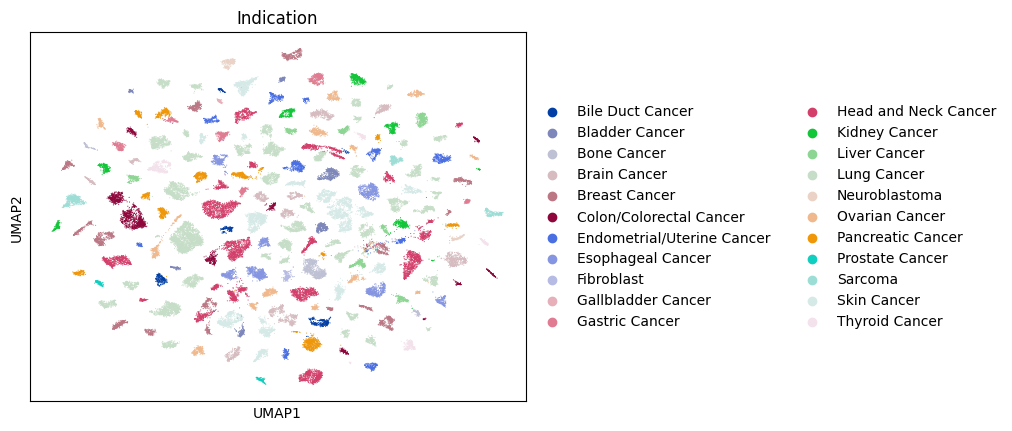

In [6]:
sc.pl.umap(adata, color=['Indication'])

## Both the plot and Figure 1B of Kinker et al. display the variability of the dataset due to differences in cell lines and indications. However, there are key differences. Figure 1B of Kinker et al. uses t-SNE to plot the clusters and focuses on only a subset of cell lines to demonstrate how well cells are assigned to their respective cell lines.

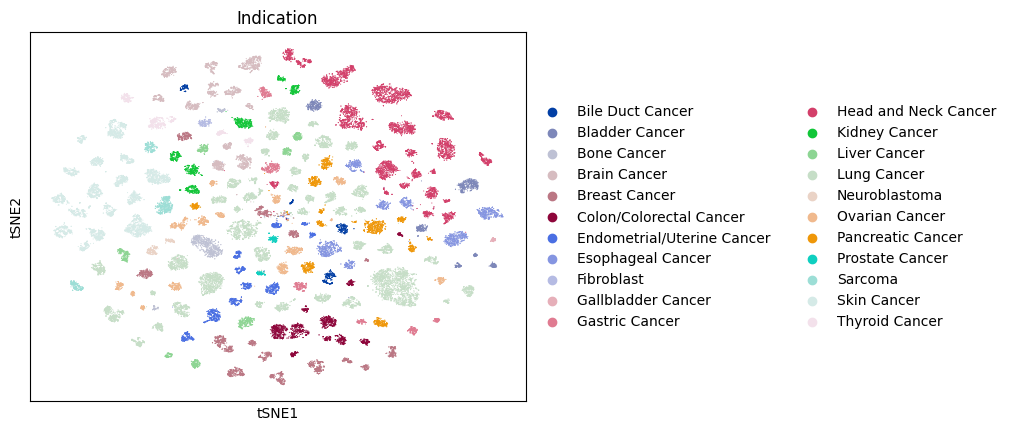

In [7]:
# plotting tSNE 
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['Indication'])  # Color by gene expression or cluster labels


## # creating a subset_adata for lung, breast, pancreatic, sarcoma and esoph


In [86]:
subset_adata=adata[(adata.obs['Indication']=='Lung Cancer')|
                   (adata.obs['Indication']=='Breast Cancer')|
                   (adata.obs['Indication']=='Pancreatic Cancer')|
                   (adata.obs['Indication']=='Sarcoma')|
                  (adata.obs['Indication']=='Esophageal Cancer')].copy()

In [90]:
# re-preprocessing
subset_adata = BasicScanpyPreprocessing(subset_adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

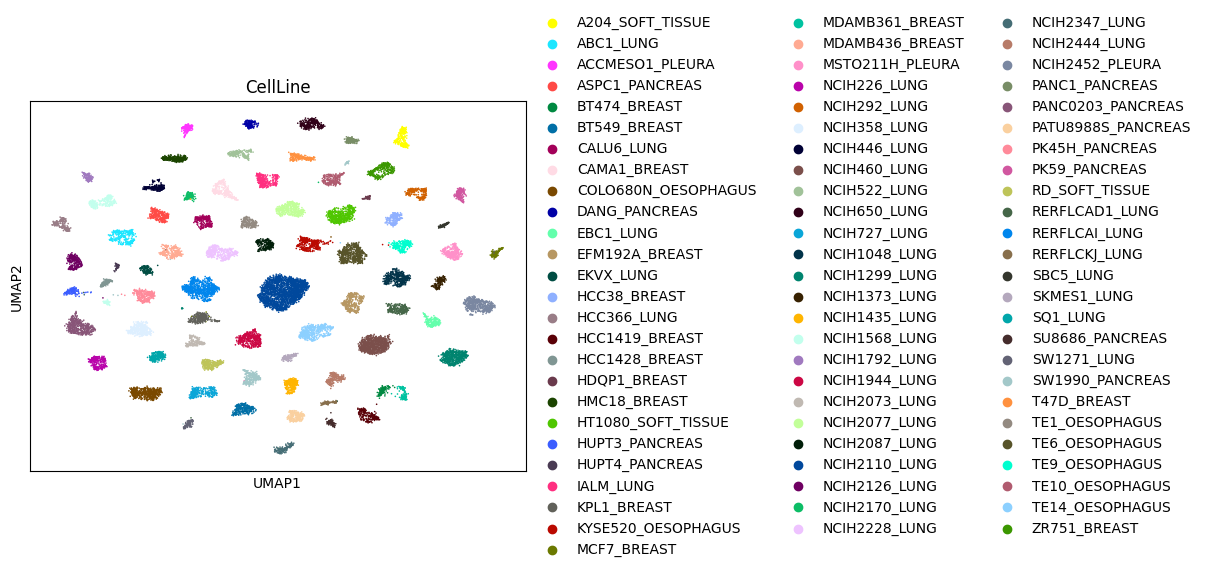

In [91]:

sc.pl.umap(subset_adata, color= 'CellLine')


In [12]:
adata.obs['CellLine']


AAACCTGAGACATAAC-1-18                       NCIH2126_LUNG
AAACCTGCACAACGCC-1-18                       SW579_THYROID
AAACCTGCAGACAAGC-1-18                            C32_SKIN
AAACCTGCAGCTCGAC-1-18                       SW579_THYROID
AAACCTGCATGGATGG-1-18                        NCIH446_LUNG
                                       ...               
c4788                    JHU029_UPPER_AERODIGESTIVE_TRACT
c4789                      SCC9_UPPER_AERODIGESTIVE_TRACT
c4793                    JHU029_UPPER_AERODIGESTIVE_TRACT
c4800                      SCC9_UPPER_AERODIGESTIVE_TRACT
c4812                      SCC9_UPPER_AERODIGESTIVE_TRACT
Name: CellLine, Length: 53513, dtype: category
Categories (198, object): ['42MGBA_CENTRAL_NERVOUS_SYSTEM', '93VU_UPPER_AERODIGESTIVE_TRACT', '8305C_THYROID', '2313287_STOMACH', ..., 'VMRCRCZ_KIDNEY', 'WM88_SKIN', 'YD38_UPPER_AERODIGESTIVE_TRACT', 'ZR751_BREAST']

# trying to construct the F2B

In [60]:
# getting out the full name of the cellline 
# i tried this for every cell line in the figure
l=[]
for i in adata.obs['CellLine']:
    if 'NCIH21' in i:
        l.append(i)
print(pd.Series(l).unique())

['NCIH2126_LUNG' 'NCIH2110_LUNG' 'NCIH2170_LUNG']


In [65]:
# creating a subset of the NCIH2126_LUNG to see intra tumer heterogeneity 
NCIH2110_LUNG_ad=adata[adata.obs['CellLine']=='NCIH2110_LUNG']
NCIH1299_LUNG_ad=adata[adata.obs['CellLine']=='NCIH1299_LUNG']
CAKI2_KIDNEY_ad= adata[adata.obs['CellLine']=='CAKI2_KIDNEY']
JHU006_UPPER_AERODIGESTIVE_TRACT_ad=adata[adata.obs['CellLine']=='JHU006_UPPER_AERODIGESTIVE_TRACT']


In [66]:
# re-processing
NCIH2110_LUNG_ad = BasicScanpyPreprocessing(NCIH2110_LUNG_ad, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=None, resolution=0.5)
NCIH1299_LUNG_ad = BasicScanpyPreprocessing(NCIH1299_LUNG_ad, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=None, resolution=0.5)
CAKI2_KIDNEY_ad = BasicScanpyPreprocessing(CAKI2_KIDNEY_ad, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=None, resolution=0.5)
JHU006_UPPER_AERODIGESTIVE_TRACT_ad = BasicScanpyPreprocessing(JHU006_UPPER_AERODIGESTIVE_TRACT_ad, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=None, resolution=0.5)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


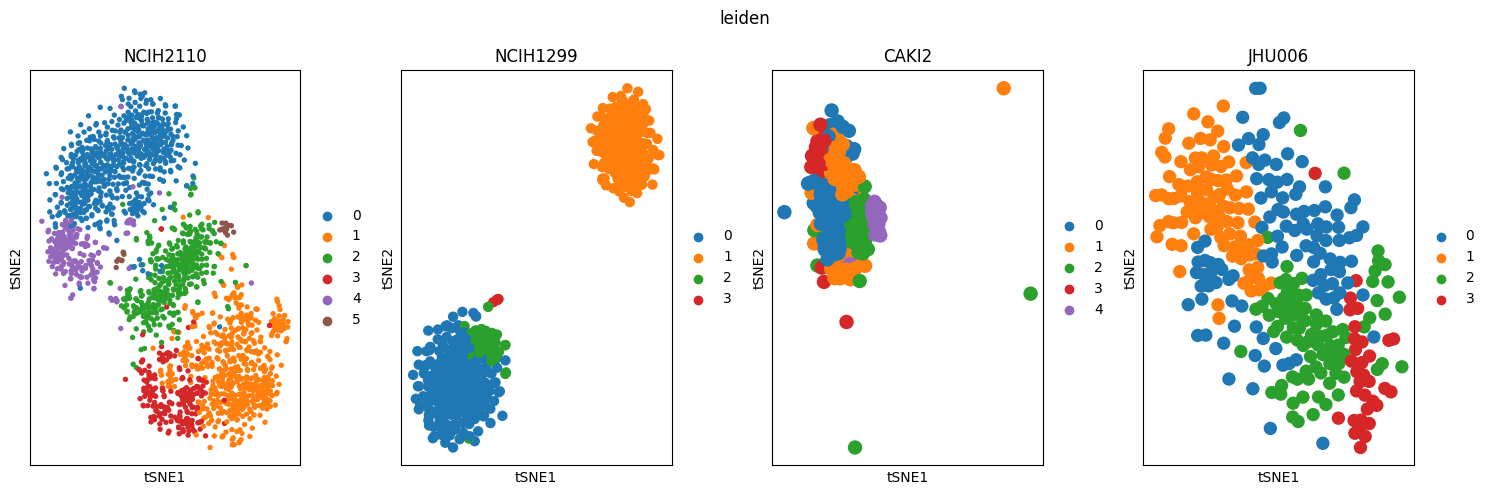

In [76]:
#ploting the tsne
fig, axe = plt.subplots(1,4,figsize=(15,5))
sc.pl.tsne(NCIH2110_LUNG_ad, color='leiden', title='NCIH2110', show=False, ax=axe[0])
sc.pl.tsne(NCIH1299_LUNG_ad, color='leiden', title='NCIH1299', show=False, ax=axe[1])
sc.pl.tsne(CAKI2_KIDNEY_ad, color='leiden', title='CAKI2', show=False, ax=axe[2])
sc.pl.tsne(JHU006_UPPER_AERODIGESTIVE_TRACT_ad, color='leiden', title='JHU006', show=False, ax=axe[3])
fig.suptitle('leiden')
plt.tight_layout()
plt.show()

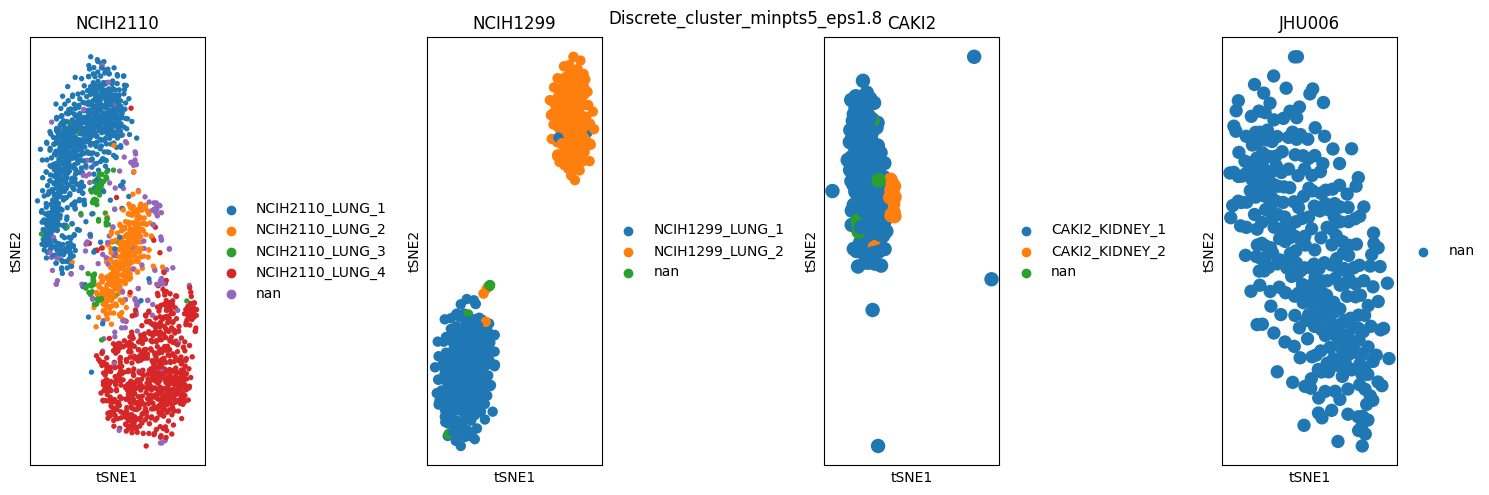

In [77]:
#ploting the tsne
fig, axe = plt.subplots(1,4,figsize=(15,5))
sc.pl.tsne(NCIH2110_LUNG_ad, color='Discrete_cluster_minpts5_eps1.8', title='NCIH2110', show=False, ax=axe[0])
sc.pl.tsne(NCIH1299_LUNG_ad, color='Discrete_cluster_minpts5_eps1.8', title='NCIH1299', show=False, ax=axe[1])
sc.pl.tsne(CAKI2_KIDNEY_ad, color='Discrete_cluster_minpts5_eps1.8', title='CAKI2', show=False, ax=axe[2])
sc.pl.tsne(JHU006_UPPER_AERODIGESTIVE_TRACT_ad, color='Discrete_cluster_minpts5_eps1.8', title='JHU006', show=False, ax=axe[3])
plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.8')
plt.show()

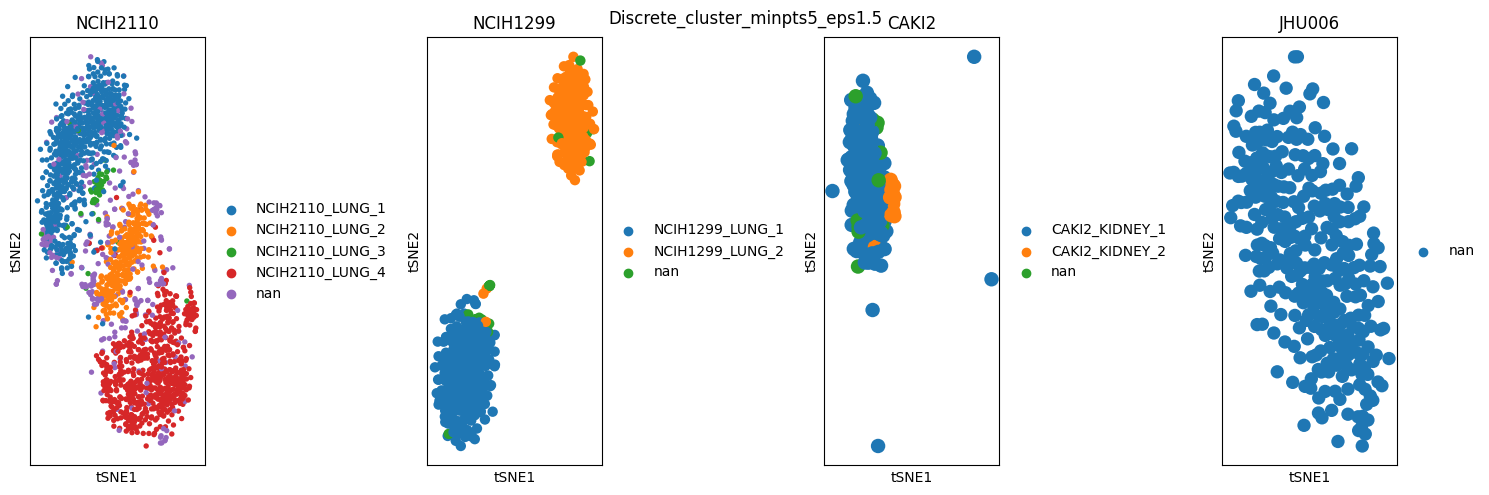

In [78]:
#ploting the tsne
fig, axe = plt.subplots(1,4,figsize=(15,5))
sc.pl.tsne(NCIH2110_LUNG_ad, color='Discrete_cluster_minpts5_eps1.5', title='NCIH2110', show=False, ax=axe[0])
sc.pl.tsne(NCIH1299_LUNG_ad, color='Discrete_cluster_minpts5_eps1.5', title='NCIH1299', show=False, ax=axe[1])
sc.pl.tsne(CAKI2_KIDNEY_ad, color='Discrete_cluster_minpts5_eps1.5', title='CAKI2', show=False, ax=axe[2])
sc.pl.tsne(JHU006_UPPER_AERODIGESTIVE_TRACT_ad, color='Discrete_cluster_minpts5_eps1.5', title='JHU006', show=False, ax=axe[3])
plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.5')
plt.show()

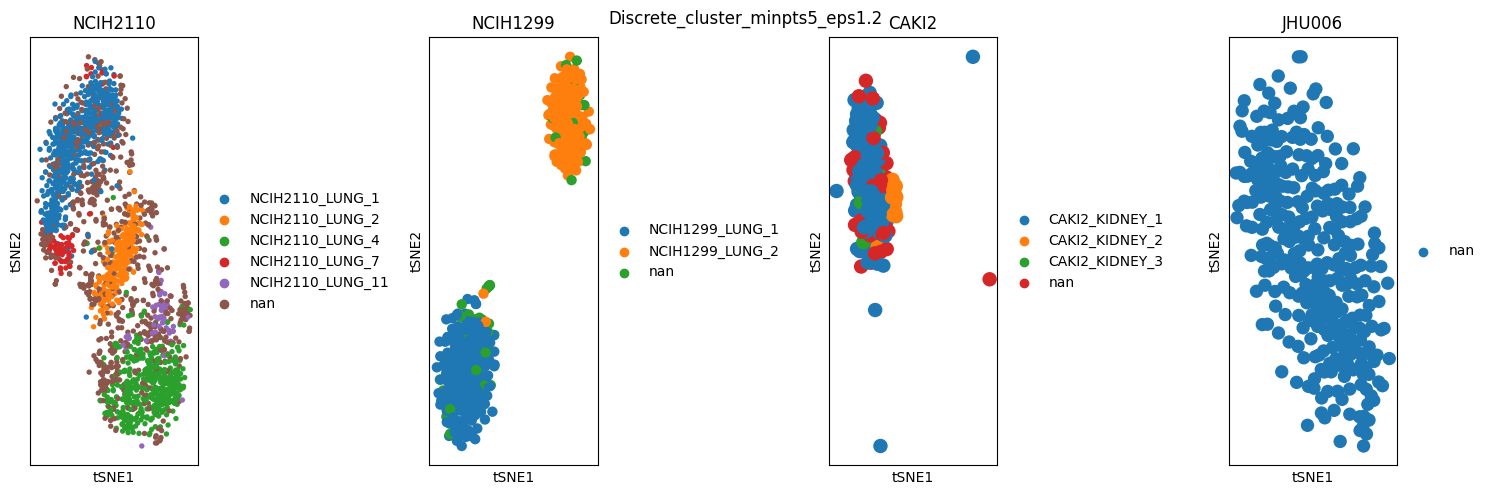

In [79]:
#ploting the tsne
fig, axe = plt.subplots(1,4,figsize=(15,5))
sc.pl.tsne(NCIH2110_LUNG_ad, color='Discrete_cluster_minpts5_eps1.2', title='NCIH2110', show=False, ax=axe[0])
sc.pl.tsne(NCIH1299_LUNG_ad, color='Discrete_cluster_minpts5_eps1.2', title='NCIH1299', show=False, ax=axe[1])
sc.pl.tsne(CAKI2_KIDNEY_ad, color='Discrete_cluster_minpts5_eps1.2', title='CAKI2', show=False, ax=axe[2])
sc.pl.tsne(JHU006_UPPER_AERODIGESTIVE_TRACT_ad, color='Discrete_cluster_minpts5_eps1.2', title='JHU006', show=False, ax=axe[3])
plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.2')
plt.show()

## the clusters identified with tnse look similar to clusters that are identified in the paper except for cell line JHU006 

# in conclusion cells seems to cluster based on their cell line of origin 

In [80]:
%who

BasicScanpyPreprocessing	 CAKI2_KIDNEY_ad	 JHU006_UPPER_AERODIGESTIVE_TRACT_ad	 NCIH1299_LUNG_ad	 NCIH2110_LUNG_ad	 NCIH2126_LUNG_ad	 adata	 adsubset_adataata	 anndata	 
axe	 dendrogram	 dill	 fig	 gene_expression	 i	 l	 linkage	 np	 
os	 pd	 plt	 sc	 scipy	 scores	 sns	 subset_adata	 


In [92]:
!mkdir outs
CAKI2_KIDNEY_ad.write('outs/CAKI2_KIDNEY_ad.h5ad')
JHU006_UPPER_AERODIGESTIVE_TRACT_ad.write('outs/JHU006_UPPER_AERODIGESTIVE_TRACT_ad.h5ad')
NCIH1299_LUNG_ad.write('outs/NCIH1299_LUNG_ad.h5ad')
NCIH2110_LUNG_ad.write('outs/NCIH2110_LUNG_ad.h5ad')
adata.write('outs/adata.h5ad')
subset_adata.write('outs/subset_adata.h5ad')